# Image Captioning 
----
This collab file consist of Image Captioning based on flickr8k dataset  

## Importing libraries

In [ ]:
import string
import numpy as np
from PIL import Image
import os
import tensorflow as tf
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Getting text data

In [ ]:
!unzip "/content/drive/MyDrive/SMIIT/Image Captioning/Flickr8k_text.zip"
!unzip "/content/drive/MyDrive/SMIIT/Image Captioning/Flickr8k_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._34295

The main text file which contains all image captions is Flickr8k.token

The format of our file is image and caption separated by a new line (“\n”).

Each image has 5 captions and we can see that #(0 to 5)number is assigned for each caption.

The Flickr.token.txt file looks like 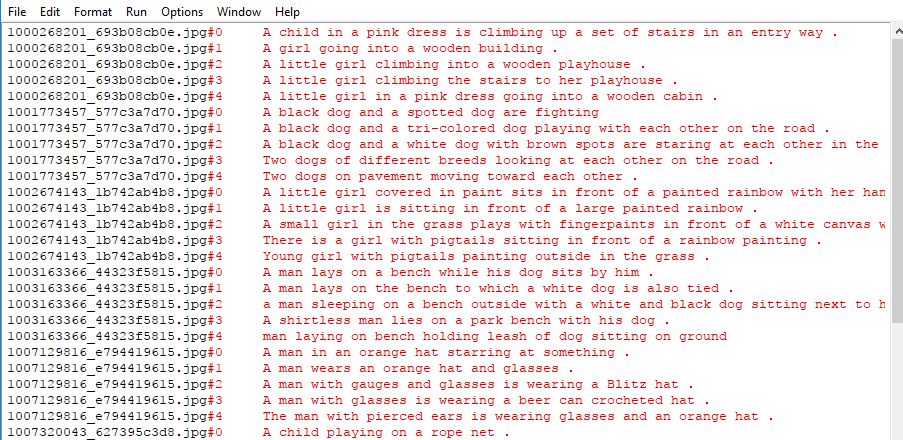

And we will convert this into 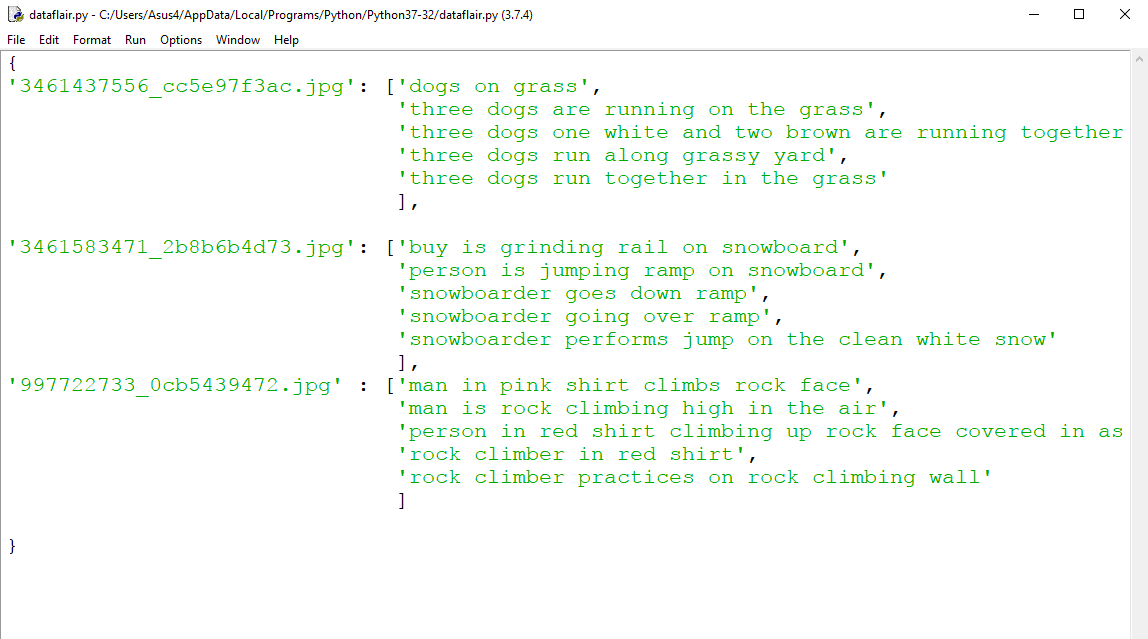

For this we will use some function described below


**load_doc**( filename ) – For loading the document file and reading the contents inside the file into a string.

***all_img_captions***( filename ) – This function will create a descriptions dictionary that maps images with a list of 5 captions. The descriptions dictionary will look something like this:

In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

    
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

***cleaning_text( descriptions)*** – This function takes all descriptions and performs data cleaning. This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers.
So, a caption like “A man riding on a three-wheeled wheelchair” will be transformed into “man riding on three wheeled wheelchair”

***text_vocabulary( descriptions )*** – This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions.

***save_descriptions( descriptions, filename )*** – This function will create a list of all the descriptions that have been preprocessed and store them into a file. We will create a descriptions.txt file to store all the captions. It will look something like this:

In [ ]:

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

    
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
# Set these path according to project folder in you system
dataset_text = "Flickr_8k_text"
dataset_images = "Flicker8k_Dataset"
#we prepare our text data
filename = "/content/Flickr8k.token.txt"
#loading the file that contains all data


#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))
print(type(descriptions))
print(descriptions)

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)


#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
print(type(vocabulary))
print(vocabulary)

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Output hidden; open in https://colab.research.google.com to view.

Till now we loaded the text

Made a set of the text 

Cleaned the text

Made a vocabulary by the given text

saved the text in "description.txt file"

## Extracting Features from images
Now lets extract features from images 


In [ ]:

# load the model
def extract_features(directory):
        model = tf.keras.applications.Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector


'features = extract_features(dataset_images)\ndump(features, open("features.p","wb"))\n '

In [ ]:
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))


## Loading the data we have and processing it

In [ ]:
features = load(open("/content/drive/MyDrive/SMIIT/Image Captioning/features.p","rb"))

In our Flickr_8k_test folder, we have Flickr_8k.trainImages.txt file that contains a list of 6000 image names that we will use for training.

For loading the training dataset, we need more functions:

***load_photos( filename ) ***– This will load the text file in a string and will return the list of image names.

***load_clean_descriptions( filename, photos )*** – This function will create a dictionary that contains captions for each photo from the list of photos. We also append the <start> and <end> identifier for each caption. We need this so that our LSTM model can identify the starting and ending of the caption.

***load_features(photos)*** – This function will give us the dictionary for image names and their feature vector which we have previously extracted from the VGG19 model.

In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/SMIIT/Image Captioning/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename ="/content/Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/SMIIT/Image Captioning/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

Computers don’t understand English words, for computers, we will have to represent them with numbers. So, we will map each word of the vocabulary with a unique index value. Keras library provides us with the tokenizer function that we will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. Max_length of description is 32.

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

Let us first see how the input and output of our model will look like. To make this task into a supervised learning task, we have to provide input and output to the model for training. We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.  

x1(feature vector)	x2(Text sequence)	y(word to predict)

feature	start,	two

feature	start, two	dogs

feature	start, two, dogs	drink

feature	start, two, dogs, drink	water

feature	start, two, dogs, drink, water	end

In [ ]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

## Defining the model

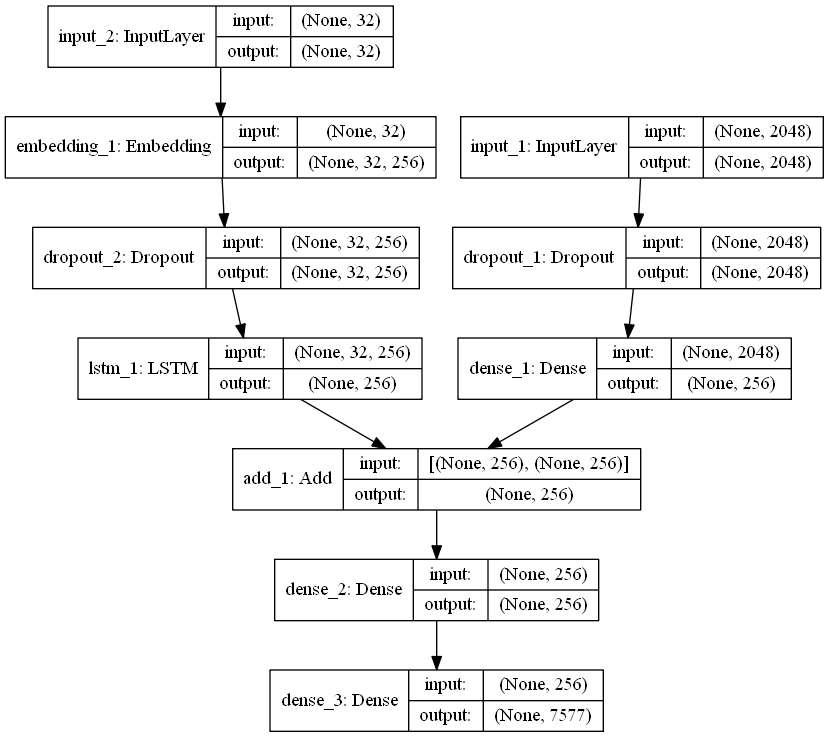

Our structure would look similar to this expect we have 4096 features and the image has 2048 features

In [ ]:
#from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Training the model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator((generator), epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 256)      1939712     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_7[0][0]      

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 617s 102ms/step - loss: 4.9896


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6000/6000 [==============================] - 601s 100ms/step - loss: 2.7855
